In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import (EfficientNetB5, preprocess_input)

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# 雲端執行須執行這行，取得權限
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 雲端執行須執行這行，變更環境路徑
os.chdir("/content/drive/Shared drives/2020 AIGO_Course/code")
os.getcwd()

'/content/drive/Shared drives/2020 AIGO_Course/code'

In [7]:
def load_image(path, img_shape):
    img = image.load_img(path, target_size=img_shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [8]:
def grad_cam(input_model, image, img_shape, category_index, layer_name):
    grad_model = Model(input_model.inputs, [input_model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions[:, category_index]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    grads_val = grads.numpy()

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, img_shape)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    
    return np.uint8(cam), heatmap


In [9]:
test_list = pd.read_csv("./data_list/test_list.csv", index_col=False)

In [10]:
data_path = "../dataset/data"
cam_path = "../dataset/grad_cam"
if not os.path.exists(cam_path):
    os.makedirs(cam_path)

In [11]:
model = load_model('./model-logs/{}-best-model.h5'.format('efficientnet'))

In [ ]:
model.summary()

In [13]:
layer_name = "top_activation"
img_shape = (456, 456)

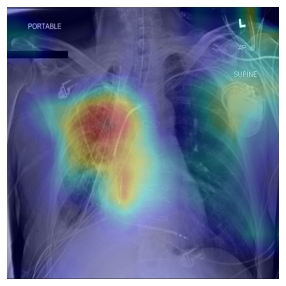

In [14]:
for each in test_list["img_name"].values[:2]:    
    preprocessed_input = load_image(os.path.join(data_path, each), img_shape)
    
    img = cv2.imread(os.path.join(data_path, each))
    img = cv2.resize(img, img_shape)
    
    predictions = model.predict(preprocessed_input)
    predicted_class = np.argmax(predictions)
    
    cam, heatmap = grad_cam(model, preprocessed_input, img_shape, predicted_class, layer_name)
    overcam = cv2.addWeighted(img, 0.8, cam, 0.3, 0)
    
    cv2.imwrite(os.path.join(cam_path, each), overcam)

plt.figure(figsize=(5, 5))
plt.imshow(overcam[:,:,::-1])
plt.axis("off")
plt.show()      
# K.clear_session() 